In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from models import *

## Десять активов, все методы

In [2]:
H = {}
H['AAPL'] = pd.read_csv("hist_data/AAPL.csv")
H['MSFT'] = pd.read_csv("hist_data/MSFT.csv")
H['GOOG'] = pd.read_csv("hist_data/GOOG.csv")
H['DIS'] = pd.read_csv("hist_data/DIS.csv")
H['UNH'] = pd.read_csv("hist_data/UNH.csv")
H['LMT'] = pd.read_csv("hist_data/LMT.csv")
H['GS'] = pd.read_csv("hist_data/GS.csv")
H['JPM'] = pd.read_csv("hist_data/JPM.csv")
H['WMT'] = pd.read_csv("hist_data/WMT.csv")
H['DB'] = pd.read_csv("hist_data/DB.csv")

q = 0.01
start = 0
begin = 365
end = None
evaluation_step = 14
samples = 30
simulations = 1000
window = True
plot_errors = False

args = start, begin, end, evaluation_step, q, samples, simulations, plot_errors, window

CB_block_size = 10   
S_block_size = 10     
MB_block_size = 10


results = pd.DataFrame()
for key in H:
    VL_BHS = BHS(H[key]).evaluate(*args)                            # Bootstrap Historical Simulation method
    VL_MC = MonteCarlo(H[key]).evaluate(*args)                      # Monte-Carlo simulation method
    VL_CB_BHS = CB_BHS(H[key], CB_block_size).evaluate(*args)       # Circular Block Bootstrap Historical Simulation method
    VL_S_BHS = S_BHS(H[key], S_block_size).evaluate(*args)          # Stationary Bootstrap Historical Simulation method
    VL_MB_BHS = MB_BHS(H[key], MB_block_size).evaluate(*args)       # Moving Block Historical Simulation method

    results[key] = [VL_BHS, VL_MC, VL_CB_BHS, VL_S_BHS, VL_MB_BHS]

results.index = ['BHS', 'MC', 'CB_BHS', 'S_BHS', 'MB_BHS']
results['Mean'] = np.mean(results.to_numpy(), 1)

In [3]:
print("VaR Violation Rate")
results

VaR Violation Rate


,AAPL,MSFT,GOOG,DIS,UNH,LMT,GS,JPM,WMT,DB,Mean
BHS,0.048387,0.000000,0.016129,0.032258,0.016129,0.032258,0.048387,0.032258,0.032258,0.016129,0.027419
MC,0.048387,0.000000,0.016129,0.032258,0.000000,0.032258,0.048387,0.032258,0.032258,0.016129,0.025806
CB_BHS,0.048387,0.000000,0.032258,0.032258,0.016129,0.032258,0.048387,0.032258,0.032258,0.016129,0.029032
S_BHS,0.032258,0.016129,0.032258,0.032258,0.016129,0.032258,0.048387,0.032258,0.032258,0.016129,0.029032
MB_BHS,0.048387,0.016129,0.032258,0.032258,0.016129,0.016129,0.048387,0.032258,0.032258,0.016129,0.029032


## Пример симуляции методом Монте-Карло


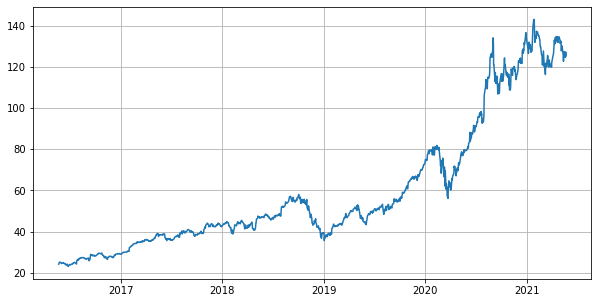

In [4]:
MC = MonteCarlo(H['AAPL'])
MC.plot()

2018-10-11 2018-11-26 30
2018-10-31 2018-12-17 30
2020-02-13 2020-03-30 30
VaR violation rate:  0.04838709677419355


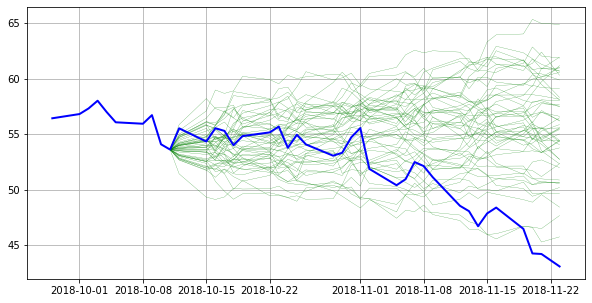

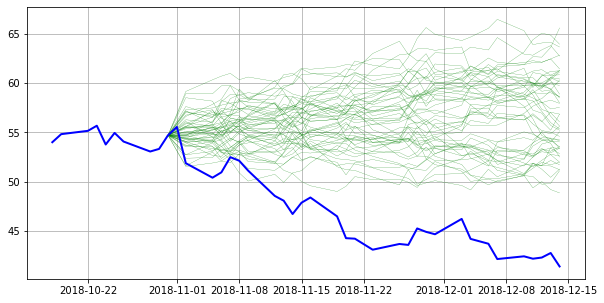

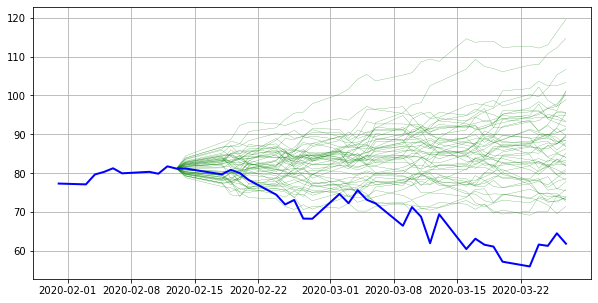

In [5]:
q = 0.01
start = 0
begin = 365
end = None
evaluation_step = 14
samples = 30
simulations = 1000
window = True
plot_errors = True

args = start, begin, end, evaluation_step, q, samples, simulations, plot_errors, window

print("VaR violation rate: ", MC.evaluate(*args))

Последняя выполненная симуляция 

2021-03-25 2021-05-10 30


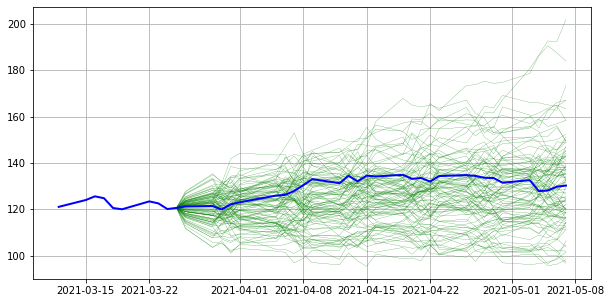

In [6]:
MC.plot_last_simulation(100, real_price=True)